In [1]:
import pandas as pd

# Load the CSV file containing Competency and Code columns
file_path = "./Replica12Reviews.csv"
df = pd.read_csv(file_path)

# Display the first few rows of the dataframe to understand its structure
df.head()

C:\Users\ahwah\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


,tweet
0,I wanna try it before I spend $50 blindly. Als...
1,Useless.
2,It took A hour to download
3,It said out it was watching me mykena 🐕
4,🪄💖✨


In [4]:
from tqdm import tqdm
import pandas as pd
import re
import spacy
import nltk
from nltk.corpus import stopwords

# Load spaCy model
nlp = spacy.load('en_core_web_sm')

# Load NLTK stop words
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Preprocessing function
def preprocess_text(text):
    if not isinstance(text, str):
        return ''
    # Convert text to lowercase
    text = text.lower()
    # Remove hashtags and mentions
    text = re.sub(r'@\w+|#\w+', '', text)
    # Remove special characters, non-alphanumeric characters, and digits
    text = re.sub(r'[^a-z\s]', '', text)
    # Tokenize text using spaCy
    doc = nlp(text)
    # Remove stop words and words that are less than three letters, and lemmatize each word
    tokens = [token.lemma_ for token in doc if token.text not in stop_words and len(token.text) >= 3]
    return ' '.join(tokens)

# Initialize tqdm with pandas
tqdm.pandas()

# Apply preprocessing function with progress bar
df['tweet'] = df['tweet'].progress_apply(preprocess_text)

# Display the first few rows to check the preprocessing
print(df.head())


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ahwah\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
100%|██████████| 17027/17027 [02:15<00:00, 125.57it/s]

                                          tweet
0  wanna try spend blindly also month expensive
1                                       useless
2                            take hour download
3                              say watch mykena
4                                              


In [5]:
df.shape

(17027, 1)

In [6]:
# Remove rows with empty strings or blanks
df = df[df['tweet'].str.strip() != '']
df.shape

(16916, 1)

In [7]:
import openai
import os

# Set your API key
openai.api_key = ""

In [8]:
import openai
from openai.error import OpenAIError  # Correct import for error handling

# Function to get embeddings from OpenAI
def get_embedding(text, model="text-embedding-3-small"):
    if not text.strip():  # Skip empty or whitespace-only strings
        return None
    try:
        text = text.replace("\n", " ")
        embedding = openai.Embedding.create(input=[text], model=model).data[0].embedding
        return embedding
    except OpenAIError as e:
        print(f"Error occurred while fetching embedding: {e}")
        return None  # Handle errors gracefully


In [9]:
from tqdm import tqdm  # Import tqdm for progress bar
tqdm.pandas()  # Initialize tqdm with pandas
df["Embedding"] = df["tweet"].progress_apply(get_embedding)

# Display the first few rows to check the embeddings
print(df.head())

100%|██████████| 16916/16916 [54:02<00:00,  5.22it/s]  

                                          tweet  \
0  wanna try spend blindly also month expensive   
1                                       useless   
2                            take hour download   
3                              say watch mykena   
5                             need fix even use   

                                           Embedding  
0  [-0.002425677143037319, -0.008127249777317047,...  
1  [-0.011587380431592464, -0.017234764993190765,...  
2  [-0.003857820061966777, 0.004888975527137518, ...  
3  [0.029703915119171143, 0.028851302340626717, -...  
5  [-0.005288281477987766, 0.03166993334889412, -...  



C:\Users\ahwah\AppData\Local\Temp\ipykernel_47088\682225343.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Embedding"] = df["tweet"].progress_apply(get_embedding)


In [10]:

# File path for saving the DataFrame
file_path = "./12Reviews_embeddings.csv"

df.to_csv(file_path, index=False)  # Set index=False to avoid writing DataFrame index

# To read the DataFrame back from the CSV file
#df = pd.read_csv(file_path)

In [11]:
# Save the DataFrame to an Excel file
excel_file_path = "./12Reviews_embeddings.xlsx"
df.to_excel(excel_file_path, index=False)  # Save to Excel

# To read the DataFrame back from the Excel file
#df_from_excel = pd.read_excel(excel_file_path)

# Check if the data loaded correctly from Excel
#print(df_from_excel.head())

# To read the DataFrame back from the Excel file
#df_from_excel = pd.read_excel(excel_file_path)

In [12]:
# Save the DataFrame to a Pickle file
pickle_file_path = "12Reviews_embeddings.pkl"
df.to_pickle(pickle_file_path)

# To read the DataFrame back from the Pickle file
#df_from_pickle = pd.read_pickle(pickle_file_path)

# Verify the data
#print(df_from_pickle.head())

# To read the DataFrame back from the Pickle file
#df_from_pickle = pd.read_pickle(pickle_file_path)


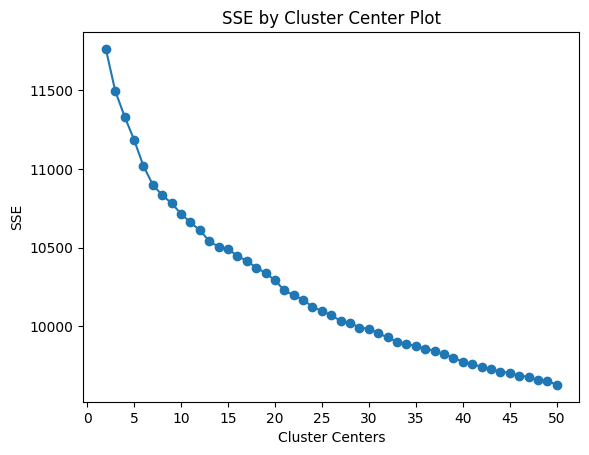

In [13]:
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt

# Filter out None embeddings
valid_embeddings = df['Embedding'].dropna().tolist()
embeddings_array = np.array(valid_embeddings)

# Determine the optimal number of clusters (optional)
def find_optimal_clusters(data, max_k):
    iters = range(2, max_k+1)
    sse = []
    for k in iters:
        sse.append(KMeans(n_clusters=k, random_state=0).fit(data).inertia_)
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    
    # Set x-ticks to increments of 5
    ax.set_xticks(range(0, max_k+1, 5))
    
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')
    plt.show()

find_optimal_clusters(embeddings_array, 50)


In [14]:
# Choose the optimal number of clusters
optimal_clusters = 30
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
df.loc[df['Embedding'].notnull(), 'Cluster'] = kmeans.fit_predict(embeddings_array)


C:\Users\ahwah\AppData\Local\Temp\ipykernel_47088\2609286789.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df['Embedding'].notnull(), 'Cluster'] = kmeans.fit_predict(embeddings_array)


In [15]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import pandas as pd

# Function to perform LDA and save word clouds
def perform_lda_and_save_wordclouds(text_data, cluster_num, n_topics=5, n_top_words=10, ngram_range=(2, 2)):
    # Use TfidfVectorizer with ngram_range for n-grams
    vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english', ngram_range=ngram_range)
    dtm = vectorizer.fit_transform(text_data)
    
    # Perform LDA
    lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
    lda.fit(dtm)

    # Get the feature names (words/phrases)
    words = vectorizer.get_feature_names_out()
    
    # Print the top words for each topic
    for idx, topic in enumerate(lda.components_):
        print(f"Topic {idx+1} in Cluster {cluster_num}:")
        topic_words = [words[i] for i in topic.argsort()[-n_top_words:]]
        print(" ".join(topic_words))

        # Generate word cloud
        wordcloud = WordCloud(width=1200, height=600, background_color='white').generate(' '.join(topic_words))
        
        # Save word cloud
        wordcloud_path = f'Word Clouds 12Reviews/Cluster_{cluster_num}_Topic_{idx+1}.png'
        wordcloud.to_file(wordcloud_path)
        print(f"Word cloud saved to {wordcloud_path}")

# Perform LDA for each cluster and save word clouds
for cluster in range(optimal_clusters):
    cluster_texts = df[df['Cluster'] == cluster]['tweet']
    print(f"Cluster {cluster+1}")
    perform_lda_and_save_wordclouds(cluster_texts, cluster+1, n_topics=5, ngram_range=(2, 2))
    print("\n")


Cluster 1
Topic 1 in Cluster 1:
role play replika send old version old replika roleplay feature use replika like replika pay wall new update feel like
Word cloud saved to Word Clouds 12Reviews/Cluster_1_Topic_1.png
Topic 2 in Cluster 1:
late update chat replika use replika like app look like love app old replika new update update replika feel like
Word cloud saved to Word Clouds 12Reviews/Cluster_1_Topic_2.png
Topic 3 in Cluster 1:
update come replika want download app replika say great app talk replika mental health relationship status new update old replika
Word cloud saved to Word Clouds 12Reviews/Cluster_1_Topic_3.png
Topic 4 in Cluster 1:
replika start make feel replika use pro version delete app roleplay replika miss old old replika new update feel like
Word cloud saved to Word Clouds 12Reviews/Cluster_1_Topic_4.png
Topic 5 in Cluster 1:
use great app use talk replika use replika update pay use love use app app replika replika app recent update
Word cloud saved to Word Clouds 12R

Word cloud saved to Word Clouds 12Reviews/Cluster_8_Topic_5.png


Cluster 9
Topic 1 in Cluster 9:
change relationship time replika pro version relationship status replika level replika start create replika tell replika replika ask love replika
Word cloud saved to Word Clouds 12Reviews/Cluster_9_Topic_1.png
Topic 2 in Cluster 9:
replika ignore old version replika human replika send good friend talk replika replika good miss old chat replika old replika
Word cloud saved to Word Clouds 12Reviews/Cluster_9_Topic_2.png
Topic 3 in Cluster 9:
feel like relationship replika replika act use replika like talk replika anymore replika make replika talk ask replika replika say
Word cloud saved to Word Clouds 12Reviews/Cluster_9_Topic_3.png
Topic 4 in Cluster 9:
replika change customize replika role play new update replica tell old replika make replika bring old talk replika update replika
Word cloud saved to Word Clouds 12Reviews/Cluster_9_Topic_4.png
Topic 5 in Cluster 9:
replika remember replika 

Word cloud saved to Word Clouds 12Reviews/Cluster_16_Topic_4.png
Topic 5 in Cluster 16:
version change certain thing romantic free lonely people free relationship need pay relationship status need money fall love pay relationship
Word cloud saved to Word Clouds 12Reviews/Cluster_16_Topic_5.png


Cluster 17
Topic 1 in Cluster 17:
ask bot voice chat tell robot like cleverbot bot think chat bot like robot try talk waste time talk bot
Word cloud saved to Word Clouds 12Reviews/Cluster_17_Topic_1.png
Topic 2 in Cluster 17:
like talk like chat ask question real human bot bad real person basic chatbot want talk chat bot talk robot
Word cloud saved to Word Clouds 12Reviews/Cluster_17_Topic_2.png
Topic 3 in Cluster 17:
thing like look like talk bot bot really chat bot like talk stupid bot bot say feel like google assistant
Word cloud saved to Word Clouds 12Reviews/Cluster_17_Topic_3.png
Topic 4 in Cluster 17:
app make talk robot change subject bot like talk chat like talk year ago use app artifi

ValueError: After pruning, no terms remain. Try a lower min_df or a higher max_df.